In [41]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
import torchvision.transforms as transforms
import torch.optim as optim
import torch.optim.lr_scheduler as sched

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from PIL import Image

In [2]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [93]:
vgg = list(torchvision.models.vgg19(pretrained=True).features[:-1].children())
vgg = nn.Sequential(*[nn.AvgPool2d(2) if isinstance(n, nn.MaxPool2d) else n for n in vgg]).to(dev)
#vgg = nn.Sequential(*vgg).to(dev)
for param in vgg.parameters():
    param.requires_grad = False
vgg.eval();

In [126]:
# All conv layers.
layer_ids = np.array([int(idx) for idx, m in vgg.named_children() if isinstance(m, nn.Conv2d)])
len(layer_ids)

16

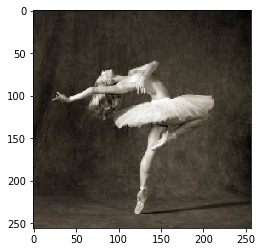

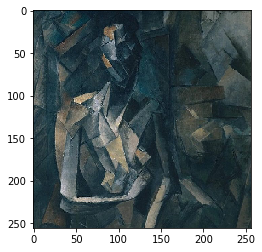

In [127]:
p = Image.open('dancing.jpg').resize((256,256))
#a = Image.open('picasso.jpg').convert('LA').convert('RGB')
a = Image.open('picasso.jpg')
a = a.resize(p.size)

plt.imshow(p)
plt.show()

plt.imshow(a)
plt.show()

In [128]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

tnorm = transforms.Compose([
    transforms.ToTensor(), # 0..1
    transforms.Normalize(mean=mean, std=std)    
])

class Denormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
    
class Clip:
    def __call__(self, tensor):
        return torch.clamp(tensor, min=0., max=1.)
    
class ToNumpy():
    def __call__(self, tensor):
        t = np.transpose(tensor.detach().numpy(), (1, 2, 0))
        t *= 255.
        return t.astype(np.uint8)
        
tdenorm = transforms.Compose([
    Denormalize(mean=mean, std=std),
    Clip(),
    ToNumpy()    
])

In [129]:
from tqdm import tqdm

class ContentLoss:
    
    def __init__(self, net, layer_id):
        self.layer_id = layer_id
        self.hook = net[layer_id].register_forward_hook(self.hookfn)        
        
    def init(self):
        # assumes net(p) called
        self.ref = self.act.clone()
        
    def hookfn(self, n, inp, outp):
        self.act = outp
        
    def remove(self):
        self.hook.remove()

    def __call__(self):
        # assumes net(x) called
        return F.mse_loss(self.act, self.ref)
        
    def __enter__(self):
        return self

    def __exit__(self, type, value, tb):
        self.remove()

class StyleLoss:
    
    def __init__(self, net, layer_ids):
        self.layer_ids = layer_ids
        self.layers = [net[l] for l in layer_ids]
        self.hooks = [l.register_forward_hook(self.hookfn) for l in self.layers]
        self.prehook = net.register_forward_pre_hook(self.prehookfn)
        self.w = 1 / len(layer_ids)
        self.act = []
        
    def hookfn(self, n, inp, outp):
        self.act.append(outp)
        
    def prehookfn(self, n, inp):
        self.act = []

    def init(self):
        # assumes net(a) called        
        self.A = [self.gram(x).clone() for x in self.act]        
        
    def remove(self):
        self.prehook.remove()
        [h.remove() for h in self.hooks]
        
    def __call__(self):
        G = [self.gram(x) for x in self.act]
        E = torch.stack([F.mse_loss(g, a) for g,a in zip(G, self.A)])
        return E.mean()
    
    def __enter__(self):
        return self

    def __exit__(self, type, value, tb):
        self.remove()
        
    def gram(self, x):
        c, n = x.shape[1], x.shape[2]*x.shape[3]
        f = x.view(c, n)
        return torch.mm(f, f.t()) / (c*n)
        

In [130]:
def max_lr(opt):
    return max([g['lr'] for g in opt.param_groups])    

def style_transfer(net, dev, p, a, cid, sids, niter=200, lr=1e-2, wc=1, ws=1e3):  
    
    p = p.to(dev).unsqueeze(0)
    a = a.to(dev).unsqueeze(0)    

    # Larger noise leads to more diverse images, but convergence is slower.
    x = torch.tensor(torch.randn_like(p)*5e-2, requires_grad=True).to(dev)
    
    xmin = -mean / std
    xmax = (1-mean) / std
    
    opt = optim.Adam([x], lr=lr)
    scheduler = sched.ReduceLROnPlateau(opt, 'min', threshold=1e-3, patience=20, cooldown=50, min_lr=1e-3)
    
    with ContentLoss(net, cid) as cl, StyleLoss(net, sids) as sl:
        net(p); cl.init()
        net(a); sl.init()

        with tqdm(total=niter) as t: 
            for idx in range(niter):
                
                opt.zero_grad()
                x.data[:,0].clamp_(xmin[0], xmax[0])
                x.data[:,1].clamp_(xmin[1], xmax[1])
                x.data[:,2].clamp_(xmin[2], xmax[2])

                net(x)
                closs = cl() * wc
                sloss = sl() * ws
                loss = closs + sloss
                loss.backward()

                opt.step()
                
                losses = np.array((closs.item(), sloss.item(), loss.item()))               
                t.set_postfix(loss=np.array_str(losses, precision=3), lr=max_lr(opt))
                t.update()
                
                scheduler.step(loss)
                
                if idx % 50 == 0:
                    yield x

In [131]:
def run_style_transfer(*args, **kwargs):
    g = style_transfer(*args, **kwargs)
    for x in g:
        pass
    return x

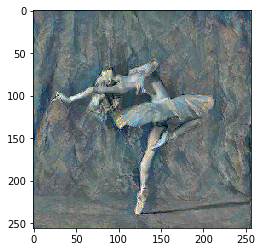

100%|███████████████████████████████| 2000/2000 [00:52<00:00, 37.87it/s, loss=[2.704e-04 6.382e-05 3.343e-04], lr=0.01]


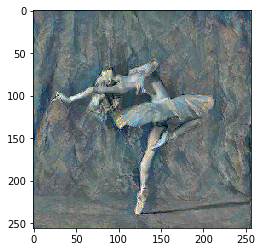

In [113]:
# interactive 

c_id = layer_ids[4]
s_ids = layer_ids[[4,8,12]]

g = style_transfer(vgg, dev, tnorm(p), tnorm(a), c_id, s_ids, niter=2000, lr=1e-2, wc=1e-3, ws=1e4);

fig, ax = plt.subplots()
img = ax.imshow(np.zeros((p.height, p.width, 3), dtype=np.uint8))

for x in g:    
    clear_output(wait=True)
    img.set_data(tdenorm(x.detach().squeeze().cpu()))
    display(fig)

100%|███████████████████████████████| 1000/1000 [00:25<00:00, 39.99it/s, loss=[4.823e-05 3.970e-05 8.793e-05], lr=0.01]


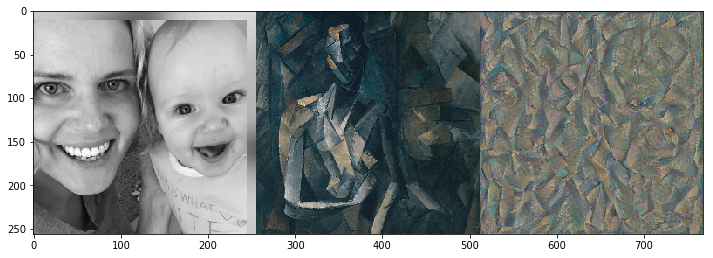

In [102]:
c_id = layer_ids[12]
s_ids = layer_ids[[4,8,12]]
x = run_style_transfer(vgg, dev, tnorm(p), tnorm(a), c_id, s_ids, niter=1000, lr=1e-2, wc=1e-3, ws=1e4);
x = tdenorm(x.squeeze().cpu())

plt.figure(figsize=(12,6))
plt.imshow(np.hstack((p, a, x)))
#plt.savefig('style-final.png', dpi=600)
plt.show()

## Parameter Evaluation

In [138]:
from itertools import product

content_choices = [2, 4, 8, 12]
style_choices = [[1,2,4], [4,6,8], [8,10,12]]

images = []
for c,s in product(content_choices, style_choices):
    x = run_style_transfer(vgg, dev, tnorm(p), tnorm(a), layer_ids[c], layer_ids[s], niter=2000, lr=1e-2, wc=1e-3, ws=1e4);
    images.append(tdenorm(x.squeeze().cpu()))

100%|███████████████████████████████| 2000/2000 [00:49<00:00, 40.04it/s, loss=[1.022e-05 1.211e-05 2.234e-05], lr=0.01]


In [139]:
def gallery(array, ncols=3):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

In [140]:
gall = gallery(np.array(images), ncols=3)

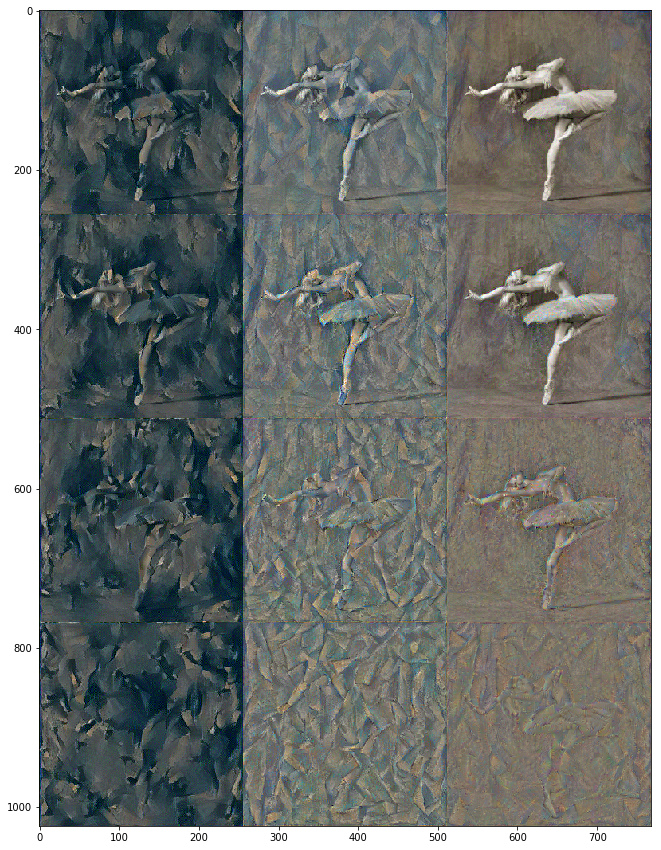

In [141]:
plt.figure(figsize=(20,15))
plt.imshow(gall)